# Metro Interstate Traffic Volume Forecasting (Part 1)
This notebook is based on chapter 12 of the book [*Time Series Forecasting in Python*](https://www.manning.com/books/time-series-forecasting-in-python-book) by Marco Peixeiro. We use a dataset for traffic forecasting. The dataset is available from the [UCI machine learning repository](https://archive.ics.uci.edu/dataset/492/metro+interstate+traffic+volume). It contains hourly Interstate 94 Westbound traffic volume, from Tuesday, October 2nd 2012, to Sunday, September 30 2018, for MN DoT ATR station 301, roughly midway between Minneapolis and St Paul, MN. Hourly weather features and holidays are used as predictors of traffic volume. The dataset does not contain missing values. We use a Python package to fetch the data from the UCI repository.

## The dataset
The dataset contains several variables that are used as features such as the meteorological variables and the type of day, holiday or not, and the traffic volume that is used as the target variable. 

In [42]:
from ucimlrepo import fetch_ucirepo 
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
#import tensorflow as tf
print("NumPy version: %s"%np.__version__)
print('Pandas version: %s'%pd.__version__)
print("matplotlib version: %s"%mpl.__version__)

NumPy version: 1.26.4
Pandas version: 2.2.2
matplotlib version: 3.8.4


We fetch the dataset using the UCI library and the dataset id

In [76]:
metro_interstate_traffic_volume = fetch_ucirepo(id=492) 

We may also use the preprocessed dataset that was made available by the author of the book. This dataset contains less records, starting from Thursday, September 29 2016, ending the same day as the remote repository, than the one available from the UCI repository and has a different structure.

In [77]:
metro_interstate_traffic_volume_preprocessed = pd.read_csv('data/metro_interstate_traffic/metro_interstate_traffic_volume_preprocessed.csv')
metro_interstate_traffic_volume_preprocessed.shape

(17551, 6)

In [94]:
metro_interstate_traffic_volume_preprocessed.head(1)

,date_time,temp,rain_1h,snow_1h,clouds_all,traffic_volume
0,2016-09-29 17:00:00,291.75,0.0,0,0,5551.0


In [95]:
metro_interstate_traffic_volume_preprocessed.tail(1)

,date_time,temp,rain_1h,snow_1h,clouds_all,traffic_volume
17550,2018-09-30 23:00:00,282.12,0.0,0,90,954.0


In [79]:
metro_interstate_traffic_volume.keys()

dict_keys(['data', 'metadata', 'variables'])

The variables are split into two Pandas DataFrame: features X and target y 

In [80]:
X = metro_interstate_traffic_volume.data.features 
y = metro_interstate_traffic_volume.data.targets 

In [81]:
X.head(1)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00


In [82]:
X.tail(1)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
48203,NaN,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00


In [48]:
X.shape

(48204, 8)

In [49]:
y.head(1)

,traffic_volume
0,5545


In [103]:
day_enum = ['Wednesday', 
            'Thursday',
            'Friday', 
            'Saturday', 
            'Sunday', 
            'Monday', 
            'Tuesday', 
            'Wednesday', 
            'Thursday', 
            'Friday', 
            'Saturday', 
            'Sunday', 
            'Monday', 
            'Tuesday', 
            'Wednesday', 
            'Thursday',
            'Friday',]

len(day_enum)

17

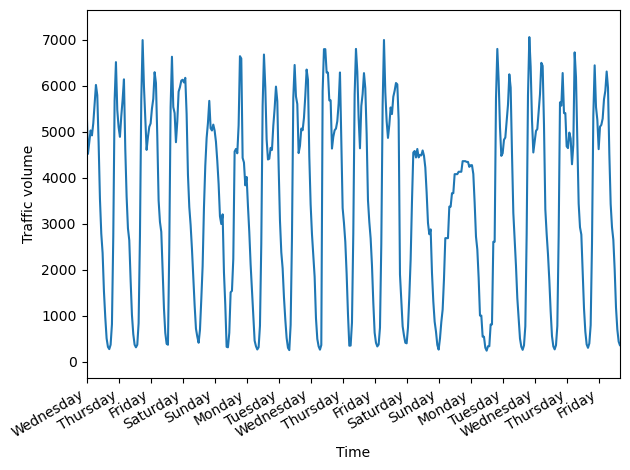

In [106]:
fig, ax = plt.subplots()
ax.plot(y['traffic_volume'])
ax.set_xlabel('Time')
ax.set_ylabel('Traffic volume')

plt.xticks(np.arange(start=0, stop=400, step=24), day_enum)
plt.xlim(0, 400)

fig.autofmt_xdate()
plt.tight_layout()

### Temperature yearly seasonality

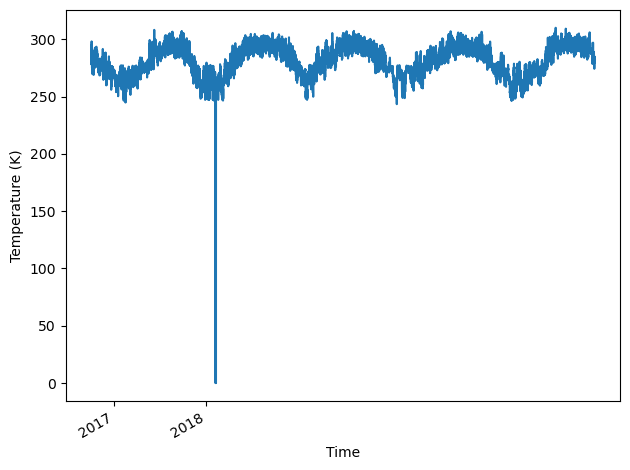

In [50]:
fig, ax = plt.subplots()

ax.plot(X['temp'])
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (K)')

plt.xticks([2239, 10999], [2017, 2018])

fig.autofmt_xdate()
plt.tight_layout()

### Temperature daily seasonality

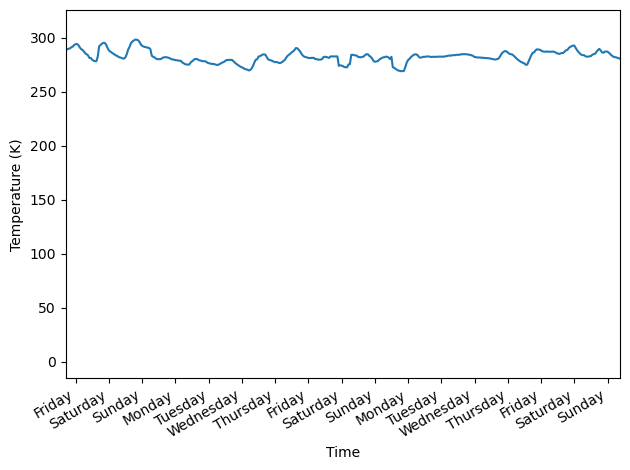

In [51]:
fig, ax = plt.subplots()

ax.plot(X['temp'])
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (K)')

plt.xticks(np.arange(start=7, stop=400, step=24), ['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlim(0, 400)

fig.autofmt_xdate()
plt.tight_layout()

In [52]:
X.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,48204.0,281.205870,13.338232,0.0,272.16,282.45,291.806,310.07
rain_1h,48204.0,0.334264,44.789133,0.0,0.00,0.00,0.000,9831.30
snow_1h,48204.0,0.000222,0.008168,0.0,0.00,0.00,0.000,0.51
clouds_all,48204.0,49.362231,39.015750,0.0,1.00,64.00,90.000,100.00


In [53]:
cols_to_drop = ['rain_1h', 'snow_1h']
X_drop = X.drop(cols_to_drop, axis=1)
X_drop.shape

(48204, 6)

In [54]:
timestamp_s = pd.to_datetime(X['date_time']).map(datetime.datetime.timestamp)

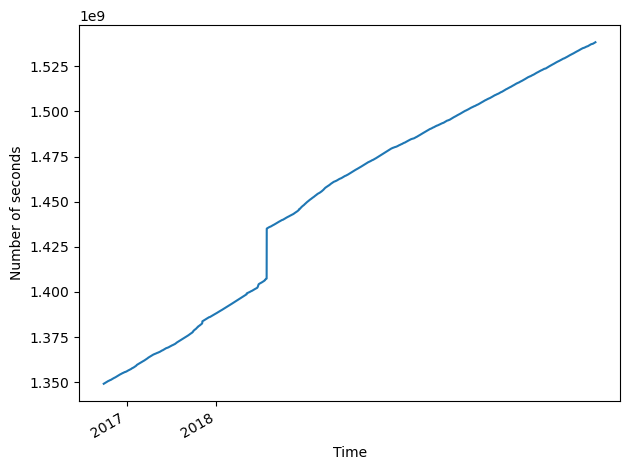

In [55]:
fig, ax = plt.subplots()

ax.plot(timestamp_s)
ax.set_xlabel('Time')
ax.set_ylabel('Number of seconds')

plt.xticks([2239, 10999], [2017, 2018])

fig.autofmt_xdate()
plt.tight_layout()

### Time cycles

In [56]:
day = 24 * 60 * 60

In [57]:
X_drop['day_sin'] = (np.sin(timestamp_s * (2*np.pi/day))).values
X_drop['day_cos'] = (np.cos(timestamp_s * (2*np.pi/day))).values

In [58]:
X_drop = X_drop.drop(['date_time'], axis=1)
X_drop.head()

,holiday,temp,clouds_all,weather_main,weather_description,day_sin,day_cos
0,NaN,288.28,40,Clouds,scattered clouds,0.965926,-0.258819
1,NaN,289.36,75,Clouds,broken clouds,0.866025,-0.500000
2,NaN,289.58,90,Clouds,overcast clouds,0.707107,-0.707107
3,NaN,290.13,90,Clouds,overcast clouds,0.500000,-0.866025
4,NaN,291.14,75,Clouds,broken clouds,0.258819,-0.965926


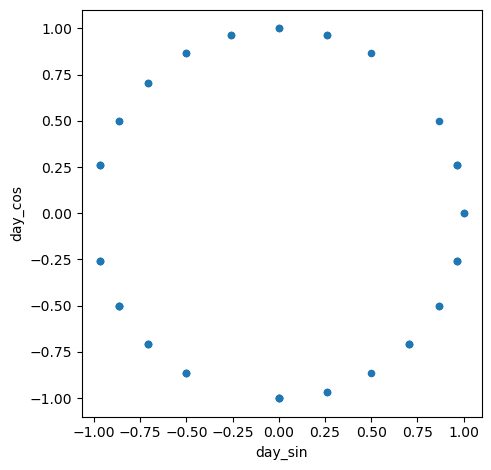

In [59]:
X_drop.sample(50).plot.scatter('day_sin','day_cos').set_aspect('equal');
plt.tight_layout()

### Training, validation, and test sets
We split the data into 70-20-10 for training, validation, and test respectively

In [60]:
X_drop = X_drop.drop(['weather_description', 'weather_main', 'holiday'], axis=1)

In [61]:
n = len(X_drop)
train_df = X_drop[0:int(n * 0.7)]
val_df = X_drop[int(n * 0.7):int(n * 0.9)]
test_df = X_drop[int(n * 0.9):]
train_df.shape, val_df.shape, test_df.shape

((33742, 4), (9641, 4), (4821, 4))

We use the [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) from scikit-learn to scale the values

In [62]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train_df)

train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

C:\Users\Luigi\AppData\Local\Temp\ipykernel_18368\2663594738.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
C:\Users\Luigi\AppData\Local\Temp\ipykernel_18368\2663594738.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
C:\Users\Luigi\AppData\Local\Temp\ipykernel_18368\2663594738.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [63]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,33742.0,0.908603,0.043526,0.0,0.881521,0.90887,0.942837,1.0
clouds_all,33742.0,0.504494,0.388716,0.0,0.010000,0.64000,0.900000,1.0
day_sin,33742.0,0.504654,0.353897,0.0,0.146447,0.50000,0.853553,1.0
day_cos,33742.0,0.506369,0.353132,0.0,0.146447,0.50000,0.853553,1.0


In [64]:
train_df.to_csv('data/metro_interstate_traffic/train.csv')
val_df.to_csv('data/metro_interstate_traffic/val.csv')
test_df.to_csv('data/metro_interstate_traffic/test.csv')